In [ ]:
import os, cv2, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.models import load_model

In [ ]:
train = pd.read_csv("/content/train.csv")

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_validate, y_train, y_test = train_test_split(train, train.label,train_size=0.8,random_state=42,stratify=train.label)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Now you can access files from Google Drive like this:
dataset_path = '/content/drive/My Drive/Tomato_images/Tomato_images'  # Update with your folder's path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Main parameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = 500
EPOCHS =10 #
IMG_WIDTH= 150
IMG_HEIGHT= 150
train_dir = '/content/drive/My Drive/Tomato_images/Tomato_images'

In [ ]:
df_train.label = df_train.label.astype('str')
df_validate.label = df_validate.label.astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               rotation_range = 180,
                               vertical_flip = True,
                               horizontal_flip = True)
# our train_datagen generator will use the following transformations on the images
validation_datagen = ImageDataGenerator(rescale=1./255)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator with rescaling and resizing
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    train_dir,
                                                    target_size=(150,150),
                                                    batch_size=16,
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode = 'categorical')

# generator = ImageDataGenerator(*args).flow_from_dataframe(dataframe, directory, target_size,
# batch_size, x_col, y_col, class_mode)
# your dataframe shoudl be in the format such that x_col = features, y_col = class/label
# binary class mode since output is either 0(dog) or 1(cat)

validation_generator = validation_datagen.flow_from_dataframe(df_validate,
                                                   train_dir,
                                                    target_size=(150,150),
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                  batch_size=16)

Found 3039 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 11489 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


Found 811 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2821 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load EfficientNetB0 model (pretrained on ImageNet)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze base model layers (optional: fine-tune later)
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # Change 10 to match your number of classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

# Callbacks: Save Best Model & Reduce Learning Rate on Plateau
checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetb0_best.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # You can increase this
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the final trained model
model.save("efficientnetb0_final.h5")
print("✅ Model training complete and saved as efficientnetb0_final.h5")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 5, 5, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,411,693 (16.83 MB)

 Trainable params: 362,122 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2724 - loss: 2.1876

190/190 ━━━━━━━━━━━━━━━━━━━━ 1515s 8s/step - accuracy: 0.2725 - loss: 2.1874 - val_accuracy: 0.3083 - val_loss: 2.0853 - learning_rate: 1.0000e-04
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 163s 747ms/step - accuracy: 0.3034 - loss: 2.1277 - val_accuracy: 0.3083 - val_loss: 2.0930 - learning_rate: 1.0000e-04
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 143s 751ms/step - accuracy: 0.2983 - loss: 2.1444 - val_accuracy: 0.3083 - val_loss: 2.0884 - learning_rate: 1.0000e-04
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.2898 - loss: 2.1524

190/190 ━━━━━━━━━━━━━━━━━━━━ 201s 745ms/step - accuracy: 0.2898 - loss: 2.1522 - val_accuracy: 0.3083 - val_loss: 2.0834 - learning_rate: 1.0000e-04
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 155s 812ms/step - accuracy: 0.2899 - loss: 2.1486 - val_accuracy: 0.3083 - val_loss: 2.0865 - learning_rate: 1.0000e-04
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.3029 - loss: 2.1185

190/190 ━━━━━━━━━━━━━━━━━━━━ 191s 754ms/step - accuracy: 0.3029 - loss: 2.1185 - val_accuracy: 0.3083 - val_loss: 2.0832 - learning_rate: 1.0000e-04
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.3010 - loss: 2.1215

190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 746ms/step - accuracy: 0.3010 - loss: 2.1215 - val_accuracy: 0.3083 - val_loss: 2.0827 - learning_rate: 1.0000e-04
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 749ms/step - accuracy: 0.2973 - loss: 2.1279 - val_accuracy: 0.3083 - val_loss: 2.0840 - learning_rate: 1.0000e-04
Epoch 9/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 201s 744ms/step - accuracy: 0.3050 - loss: 2.1143 - val_accuracy: 0.3083 - val_loss: 2.0914 - learning_rate: 1.0000e-04
Epoch 10/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 746ms/step - accuracy: 0.3151 - loss: 2.0963 - val_accuracy: 0.3083 - val_loss: 2.0928 - learning_rate: 1.0000e-04


✅ Model training complete and saved as efficientnetb0_final.h5


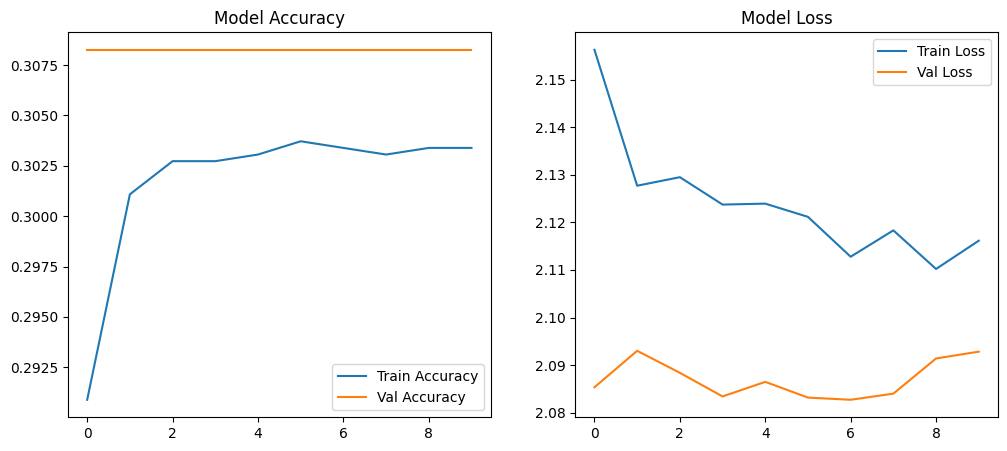

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


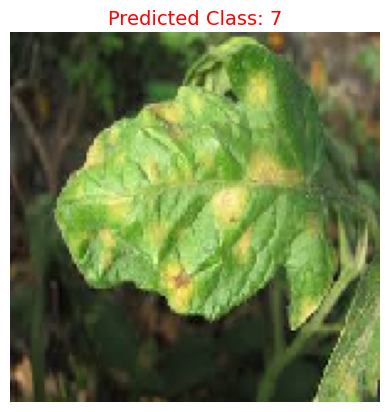

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("efficientnetb0_final.h5")

# Load an image for testing
img_path = "/content/images.jpeg"  # Change to your image path
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to array
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Class: {predicted_class}", fontsize=14, color='red')
plt.show()
